# Error Evaluation
This notebook aims to analyse and evaluate the performance of `PDEsolver`, and then compare with the existing PDE solving package -- `py-pde`. `py-pde` uses finite difference methods to solve for the PDE solutions, and the package support solving PDEs in higher dimensions and multi-order cases.

In [1]:
# Import all neceassary modules
import PDEsolver as pde
import numpy as np
from scipy.integrate import solve_ivp
import timeit
import matplotlib.pyplot as plt

---
## (1) Convergence and Run-time Analysis
We will test how error change with the choice of x using the Advection-diffusion equation with initial condition equals to the Gaussian function. Error is being calculated as the absolute mean error at $t_{final}$. Three cases being tested are the advection only ($v = 0.5$), diffusion only ($D = 0.5$), and both advection and diffusion ($v = 0.5, D = 0.5$).

In [2]:
# Define the time domain and necessary functions
t = pde.time_domain(10,0.1)

def gaussian_solution(t, x, σ, D): 
    '''
    This is a function that returns the Gaussian solution at time = t, domain = x, initial width of the curve = σ, and diffusivity = D.
    '''
    return σ / np.sqrt(σ**2 + 2*D*t) * np.exp(-x**2 / (2*(σ**2 + 2*D*t)))

def analytical_sol(x,t,D,v):
    '''
    This function returns a numpy array that contains the analytical solution of the Gaussian function with advection and diffusion based on the advection-diffusion equation. 
    The dimension of the matrix is len(x) * len(t), which means each column of the matrix is the solution at time = t.
    '''
    analytical_sol = np.zeros((len(x),len(t)))
    for i in range(len(t)):
        analytical_sol[:,i] = gaussian_solution(t[i],x - v*t[i],0.8,D)
    return analytical_sol

In [3]:
def test_convergence_runtime(num_v,D,v,method):
    '''
    This test calculates the absolute mean error and run-time of PDE solutions with changing x domain resolution.
    This function returns two numpy arrays that are the error array and the run-time array.
    '''
    error_array = []
    runtime_array = []
    
    for i in range(1,num_v):
        grid = pde.create_grid(10*np.pi,2**i)
        x = grid.x
        u0 = gaussian_solution(0,x,0.8,0)
        
        start = timeit.default_timer()
        numerical_sol = solve_ivp(pde.adv_diff_eq,[t[0],t[-1]],u0,args=(grid,D,v),t_eval=t,method=method)
        end = timeit.default_timer()
        runtime = end - start
        runtime_array.append(runtime)

        numerical_f = numerical_sol.y[:,-1]
        analytical_f = analytical_sol(x,t,D,v)[:,-1]
    
        mean_error = np.abs(numerical_f - analytical_f).mean()
        error_array.append(mean_error)

    return error_array, runtime_array

In [4]:
# Calculate the error and runtime for the three different cases and for two different integration method
error_do_d,time_do_d = test_convergence_runtime(11,0.5,0.0,'DOP853')
error_ao_d,time_ao_d = test_convergence_runtime(11,0.0,0.5,'DOP853')
error_both_d,time_both_d = test_convergence_runtime(11,0.5,0.5,'DOP853')
error_do_l,time_do_l = test_convergence_runtime(11,0.5,0.0,'LSODA')
error_ao_l,time_ao_l = test_convergence_runtime(11,0.0,0.5,'LSODA')
error_both_l,time_both_l = test_convergence_runtime(11,0.5,0.5,'LSODA')

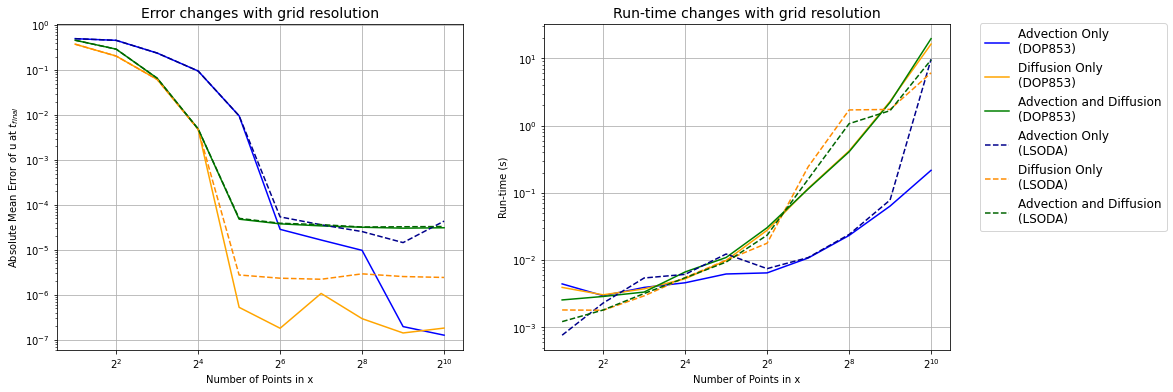

In [5]:
# Plots for the above calculation
fig,axes = plt.subplots(1,2,figsize = (16,6))
num_points = 2**np.arange(1,11)

ax1 = axes[0]
ax1.plot(num_points,error_ao_d,'b-',label='Advection Only\n(DOP853)')
ax1.plot(num_points,error_do_d,'-',color='orange',label='Diffusion Only\n(DOP853)')
ax1.plot(num_points,error_both_d,'g-',label='Advection and Diffusion\n(DOP853)')
ax1.plot(num_points,error_ao_l,'--',color='darkblue',label='Advection Only\n(LSODA)')
ax1.plot(num_points,error_do_l,'--',color='darkorange',label='Diffusion Only\n(LSODA)')
ax1.plot(num_points,error_both_l,'--',color='darkgreen',label='Advection and Diffusion\n(LSODA)')
ax1.set_xscale('log',base=2)
ax1.set_yscale('log')
ax1.set_xlabel('Number of Points in x')
ax1.set_ylabel('Absolute Mean Error of u at $t_{final}$')
ax1.set_title('Error changes with grid resolution',fontsize=14)
ax1.grid()

ax2 = axes[1]
ax2.plot(num_points, time_ao_d, 'b-')
ax2.plot(num_points, time_do_d, '-',color='orange')
ax2.plot(num_points, time_both_d, 'g-')
ax2.plot(num_points,time_ao_l,'--',color='darkblue')
ax2.plot(num_points,time_do_l,'--',color='darkorange')
ax2.plot(num_points,time_both_l,'--',color='darkgreen')
ax2.set_xscale('log',base=2)
ax2.set_yscale('log')
ax2.set_xlabel('Number of Points in x')
ax2.set_ylabel('Run-time (s)')
ax2.set_title('Run-time changes with grid resolution',fontsize=14)
ax2.grid()

ax1.legend(fontsize = 12,bbox_to_anchor=(2.75, 1.02))
plt.show()

> #### **Comment:**  
> **Left plot:** The error generally becomes small enough and stable at around $2^6$ points, which is 64 points in x. This suggests that solutions generally converge quickly in terms of spatial resolution, and using a small number of points can find a relatively accurate answer using the pseudo-spectral method. Although we have seen that the 'LSODA' method generally returns better and smoother solutions comparing to those of the 'DOP853' method in the `Project_user.ipynb` user examples, this plot demonstrates that this is not the case if we evaluate the absolute error of the final state solution. The 'DOP853' solutions are have smaller errors comparing with the anlaytical solutions generally. The 'LSODA' solutions did converge, but they generally have a larger absolute error, while they are smoother.  
> **Right plot:** The run-time increase logrithmically as shown in the right plot. There does not exist a large difference between the 'DOP853' method and the 'LSODA' method. Generally, the `PDEsolver` has a low run-time until $2^{10} = 1024$ points, and the 'LSODA' method has a little better performance compare to the 'DOP853' method. 

----
## (2) Comparison to using `py-pde`
Currently, people use the `py-pde` package to solve for PDEs in Python. Therefore, this section compares the performances of solving one-dimensional first-order PDEs between using the self-developed `PDEsolver` and the `py-pde`. The *"Diffusion Only"* case will be used to compare the performances as the diffusion equation is a built-in function in `py-pde`. Firstly, the `py-pde` package is imported below.

In [6]:
import pde as pypde
import warnings
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [7]:
def pypde_comparison(num_v,D):
    '''
    This function calculates the same two properties as the function `test_covergence_runtime()` above. However, this function is modified to be suitable for the solutions calculated by `py-pde`.
    This test calculates the absolute mean error and run-time of PDE solutions with changing x domain resolution.
    This function returns two numpy arrays that are the error array and the run-time array.
    '''
    error_array = []
    runtime_array = []
    
    for i in range(1,num_v):
        grid_resol = 2**i
        x_v = pypde.CartesianGrid([[-5*np.pi-10*np.pi/grid_resol,5*np.pi-10*np.pi/grid_resol]], grid_resol,periodic=True)    # Spatial grid
        eq = pypde.DiffusionPDE(diffusivity=D, noise=0, bc='periodic')         # PDE
        u0 = gaussian_solution(0,x_v.axes_coords[0],0.8,0)
        field = pypde.ScalarField(x_v,u0)                               # Initial condition

        start = timeit.default_timer()
        storage = pypde.MemoryStorage()
        sol_f = eq.solve(field,t_range=(0,9.9),dt=0.1,tracker=storage.tracker(0.1),solver='ScipySolver') # Numerical solution by py-pde
        end = timeit.default_timer()
        runtime = end - start
        runtime_array.append(runtime)

        numerical_f = storage.data[-1]
        analytical_f = analytical_sol(x_v.axes_coords[0],t,D,0)[:,-1]
    
        mean_error = np.abs(numerical_f - analytical_f).mean()
        error_array.append(mean_error)
    
    return error_array, runtime_array

In [8]:
# Error and run-time using py-pde to calculate solutions
error_pypde,time_pypde = pypde_comparison(11,0.4)

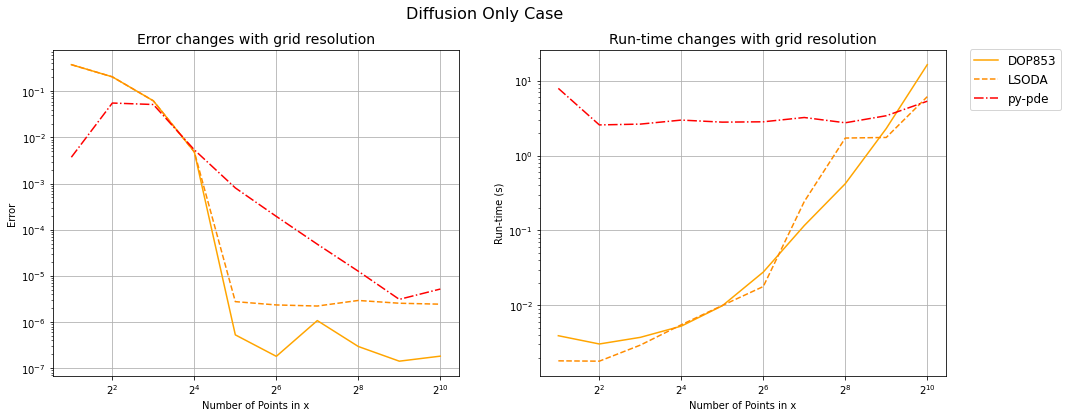

In [9]:
# Plots for comparing `PDEsolver` and `py-pde`
fig,axes = plt.subplots(1,2,figsize = (16,6))
num_points = 2**np.arange(1,11)

ax1 = axes[0]
ax1.plot(num_points,error_do_d,'-',color='orange',label='DOP853')
ax1.plot(num_points,error_do_l,'--',color='darkorange',label='LSODA')
ax1.plot(num_points,error_pypde,'-.',color='red',label = 'py-pde')
ax1.set_xscale('log',base=2)
ax1.set_yscale('log')
ax1.set_xlabel('Number of Points in x')
ax1.set_ylabel('Error')
ax1.set_title('Error changes with grid resolution',fontsize=14)
ax1.grid()

ax2 = axes[1]
ax2.plot(num_points, time_do_d, '-',color='orange')
ax2.plot(num_points,time_do_l,'--',color='darkorange')
ax2.plot(num_points,time_pypde,'-.',color='red')
ax2.set_xscale('log',base=2)
ax2.set_yscale('log')
ax2.set_xlabel('Number of Points in x')
ax2.set_ylabel('Run-time (s)')
ax2.set_title('Run-time changes with grid resolution',fontsize=14)
ax2.grid()

plt.suptitle('Diffusion Only Case',fontsize=16)
ax1.legend(fontsize = 12,bbox_to_anchor=(2.5, 1.02))
plt.show()

> #### **Comment:**
> **Left plot:** The error of `py-pde` calculated solution decreases approximately linearly in the logrithmic scale. The convergence rate is slower comparing to the `PDEsolver` solutions and it took more spatial resolution to reach around $10^{-6}$ accuracy. This plot shows that `PDEsolver` does have a similar and even better approximating accuracy compared to `py-pde`.  
> **Right plot:** The run-time of `py-pde` calculation is very stable. It takes around 3s to calculate the solution at any spatial resolution. In terms of the run-time, it is better to use `PDEsolver` for solving PDEs when the spatial resolution is coarse, less than 1000 points. When the grid resolution is fine, `py-pde` is a better choice due to its stable run-time. 

---
## Conclusion
We have shown the successful convergence of PDE solutions solved using the `PDEsolver`, minimum resolution for convergence is at around 64 points. The run-time of `PDEsolver` calculations are also relatively acceptable, especially for small spatial resolutions. Comparing to the existing PDE solving package `py-pde`, the performance of `PDEsolver` is good in terms of both small error and quick run-time.